PKAC Orang Tua Jatuh 👴 😵 🤸 🤕 ☠

Masih progress.

Biar semua gk sama persis,
- Datasetnya diganti masing-masing, jangan pakai video yg ada di sini,
- dan diketik ulang sama diganti dikit2 kodenya.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

VIDEO_PATH = Path('datasets/fenix/fall-01-cam0.mp4')
# x, y, w, h
CROP_REGION_RELATIVE = (0.5, 0, 0.5, 1)

In [2]:
cap = cv.VideoCapture(str(VIDEO_PATH))

# Cropping
orig_w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
crop_x, crop_y, crop_w, crop_h = [
    int(v)
    for v in (
        orig_w * CROP_REGION_RELATIVE[0],
        orig_h * CROP_REGION_RELATIVE[1],
        orig_w * CROP_REGION_RELATIVE[2],
        orig_h * CROP_REGION_RELATIVE[3],
    )
]

def pre_crop(frame):
    return frame[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]


In [3]:
frames: list[np.ndarray] = []
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = pre_crop(frame)
    frames.append(frame)

    if cv.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv.destroyAllWindows()

In [4]:
for frame in frames:
    cv.imshow("Frame", frame)
    if cv.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv.destroyAllWindows()

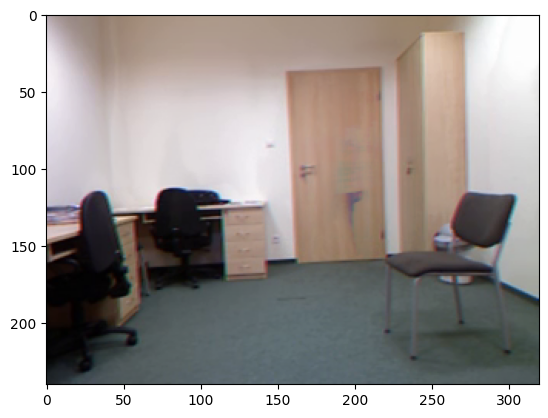

In [5]:
# Background estimation

bg = np.median(frames, axis=0).astype(np.uint8)
bg_gray = cv.cvtColor(bg, cv.COLOR_BGR2GRAY)
plt.imshow(bg[..., ::-1])

In [6]:
frames_mask = []

# Substract frame from background
for frame in frames:
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    diff = cv.absdiff(frame_gray, bg_gray)
    mask = cv.threshold(diff, 50, 255, cv.THRESH_BINARY)[1]
    frames_mask.append(mask)
    cv.imshow("Frame", mask)
    if cv.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv.destroyAllWindows()

In [7]:
# Dense optical flow
i = 0
for frame in frames:
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if "prev_gray" in locals():
        flow = cv.calcOpticalFlowFarneback(prev_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
        hsv = np.zeros_like(frame)
        hsv[..., 1] = 255
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
        bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        cv.imshow("Frame", bgr)
        if cv.waitKey(1) & 0xFF == ord("q"):
            break
    prev_gray = frame_gray
    i += 1

cap.release()
cv.destroyAllWindows()